### Imports

In [1]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from statsmodels.tsa.seasonal import seasonal_decompose

### Importation des données

In [2]:
# lire le dataset
df = pd.read_csv('data/default_nyc_taxi.csv')
df.head()

,timestamp,value,class
0,2014-07-01 00:00:00,10844,0
1,2014-07-01 00:30:00,8127,0
2,2014-07-01 01:00:00,6210,0
3,2014-07-01 01:30:00,4656,0
4,2014-07-01 02:00:00,3820,0


### Traitements des variables

In [3]:
# taille du dataset
df.shape

(10320, 3)

In [4]:
# type des variables
df.dtypes

timestamp    object
value         int64
class         int64
dtype: object

In [5]:
# type des variables
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.dtypes

timestamp    datetime64[ns]
value                 int64
class                 int64
dtype: object

In [6]:
# verifie les valeurs manquantes
df.isnull().sum()

timestamp    0
value        0
class        0
dtype: int64

### Feature Engineering

In [7]:
# decompose le timestamp en annee, mois, ...
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['weekend'] = (df['dayofweek'] > 5).astype(int)
df['daylight'] = ((df['hour']>=7) & (df['hour']<=20)).astype(int)

In [8]:
# recupere les anomalies du dataset
with open("data/labels.json", 'r') as file:
    labels = json.load(file)
    
path = 'realKnownCause/nyc_taxi.csv'
anomaly_points = labels[path]
anomaly_points

[['2014-10-30 15:30:00.000000', '2014-11-03 22:30:00.000000'],
 ['2014-11-25 12:00:00.000000', '2014-11-29 19:00:00.000000'],
 ['2014-12-23 11:30:00.000000', '2014-12-27 18:30:00.000000'],
 ['2014-12-29 21:30:00.000000', '2015-01-03 04:30:00.000000'],
 ['2015-01-24 20:30:00.000000', '2015-01-29 03:30:00.000000']]

### Corrélation des variables avec la variable cible

In [9]:
# affiche les correlations des variables avec la target
df.corrwith(df['class'])

C:\Users\Josh\AppData\Local\Temp\ipykernel_8776\3259571697.py:2: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corrwith(df['class'])


value       -0.091226
class        1.000000
year         0.150456
month       -0.006302
day          0.195688
hour         0.006632
dayofweek   -0.001626
weekend     -0.044522
daylight    -0.001858
dtype: float64

C:\Users\Josh\AppData\Local\Temp\ipykernel_8776\1548516413.py:2: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corrwith(df['class']).reset_index()


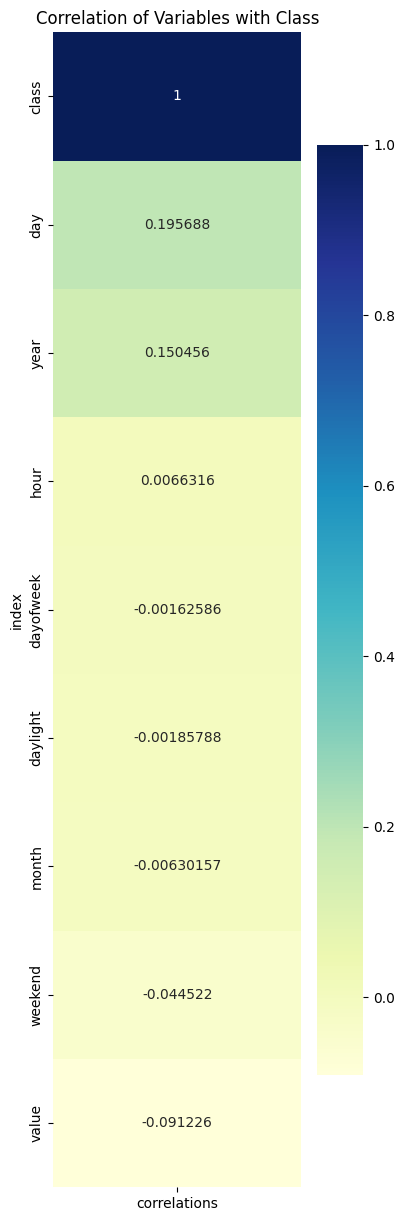

In [10]:
# affiche les correlations des variables avec la target
corr = df.corrwith(df['class']).reset_index()
corr.columns = ['index','correlations']
corr = corr.set_index('index')
corr = corr.sort_values(by=['correlations'], ascending = False)
plt.figure(figsize=(4,15))
fig = sns.heatmap(corr, annot=True, fmt="g", cmap='YlGnBu')
plt.title("Correlation of Variables with Class")
plt.show()

### Exploration du jeu de données

In [11]:
# voir le format et la frequence de timestamp
print(df['timestamp'].head(10))

0   2014-07-01 00:00:00
1   2014-07-01 00:30:00
2   2014-07-01 01:00:00
3   2014-07-01 01:30:00
4   2014-07-01 02:00:00
5   2014-07-01 02:30:00
6   2014-07-01 03:00:00
7   2014-07-01 03:30:00
8   2014-07-01 04:00:00
9   2014-07-01 04:30:00
Name: timestamp, dtype: datetime64[ns]


In [12]:
# decompose le dataset en deux datasets : anomalies et non anomalies
df_normal = df[df['class'] == 0]
df_anomaly = df[df['class'] == 1]

In [13]:
# description des anomalies
print('Description des anomalies')
df_anomaly.describe()

Description des anomalies


,value,class,year,month,day,hour,dayofweek,weekend,daylight
count,1030.000000,1030.0,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,13236.427184,1.0,2014.302913,8.205825,21.071845,11.637864,2.990291,0.093204,0.580583
std,7027.165945,0.0,0.459741,4.781765,11.015348,6.985889,1.781533,0.290859,0.493703
min,8.000000,1.0,2014.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,7001.000000,1.0,2014.000000,1.000000,23.000000,5.250000,2.000000,0.000000,0.000000
50%,14105.000000,1.0,2014.000000,11.000000,26.000000,12.000000,3.000000,0.000000,1.000000
75%,18552.750000,1.0,2015.000000,12.000000,28.000000,18.000000,4.000000,0.000000,1.000000
max,39197.000000,1.0,2015.000000,12.000000,31.000000,23.000000,6.000000,1.000000,1.000000


In [14]:
# description des non anomalies
print('Description des non anomalies')
df_normal.describe()

Description des non anomalies


,value,class,year,month,day,hour,dayofweek,weekend,daylight
count,9290.000000,9290.0,9290.000000,9290.000000,9290.000000,9290.000000,9290.000000,9290.000000,9290.000000
mean,15348.352637,0.0,2014.126588,8.276857,15.282670,11.484715,3.001076,0.144672,0.583638
std,6897.893807,0.0,0.332528,3.185781,8.400742,6.915670,2.010147,0.351788,0.492982
min,1431.000000,0.0,2014.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,10911.000000,0.0,2014.000000,7.000000,8.000000,6.000000,1.000000,0.000000,0.000000
50%,16937.000000,0.0,2014.000000,9.000000,15.000000,11.000000,3.000000,0.000000,1.000000
75%,20033.000000,0.0,2014.000000,10.000000,22.000000,17.000000,5.000000,0.000000,1.000000
max,30373.000000,0.0,2015.000000,12.000000,31.000000,23.000000,6.000000,1.000000,1.000000


In [15]:
# affiche la duree, la moyenne et la frequence des anomalies
i=1
duration_anomaly = pd.to_datetime(0)
for start, end in anomaly_points:
    print(f'Anomalie {i}')

    # duree
    duration = pd.to_datetime(end) - pd.to_datetime(start)
    duration_anomaly += duration
    print(f"Durée : {duration}")

    # moyenne
    print(f"Moyenne des passagers : {df[((df['timestamp'] > start) & (df['timestamp'] < end))]['value'].mean()} \n")
    i+=1

# frequence
duration_total = (df['timestamp'][len(df)-1] - df['timestamp'][0]).days
frequency = duration_anomaly.day/duration_total*30
print(f"Nombre d'anomalies par mois : {frequency}")

Anomalie 1
Durée : 4 days 07:00:00
Moyenne des passagers : 17440.81463414634 

Anomalie 2
Durée : 4 days 07:00:00
Moyenne des passagers : 13487.4 

Anomalie 3
Durée : 4 days 07:00:00
Moyenne des passagers : 11174.868292682926 

Anomalie 4
Durée : 4 days 07:00:00
Moyenne des passagers : 13820.414634146342 

Anomalie 5
Durée : 4 days 07:00:00
Moyenne des passagers : 10255.087804878049 

Nombre d'anomalies par mois : 3.0841121495327104


In [16]:
# distribution de la variable cible
df["class"].value_counts(normalize=True)

0    0.900194
1    0.099806
Name: class, dtype: float64

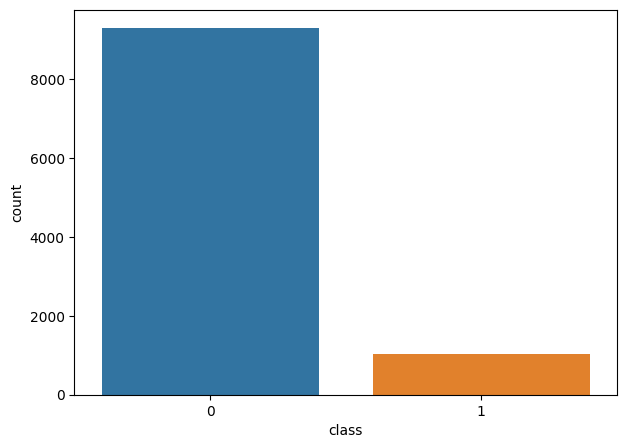

In [17]:
# distribution de la variable cible
plt.figure(figsize=(7,5))
fig = sns.countplot(x="class", data=df)
plt.show()

C:\Users\Josh\AppData\Local\Temp\ipykernel_8776\3855176876.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  fig = sns.distplot(df['timestamp'], kde=False, color="green")


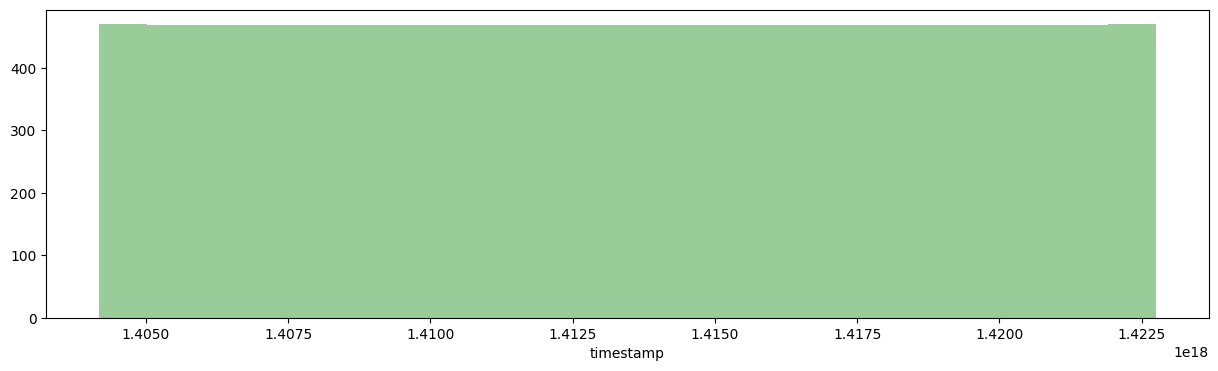

In [18]:
# distribution de la variable temps
plt.figure(figsize=(15,4))
fig = sns.distplot(df['timestamp'], kde=False, color="green")
plt.show()

C:\Users\Josh\AppData\Local\Temp\ipykernel_8776\1766781809.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  fig = sns.distplot(df["value"], kde=False, color="blue")


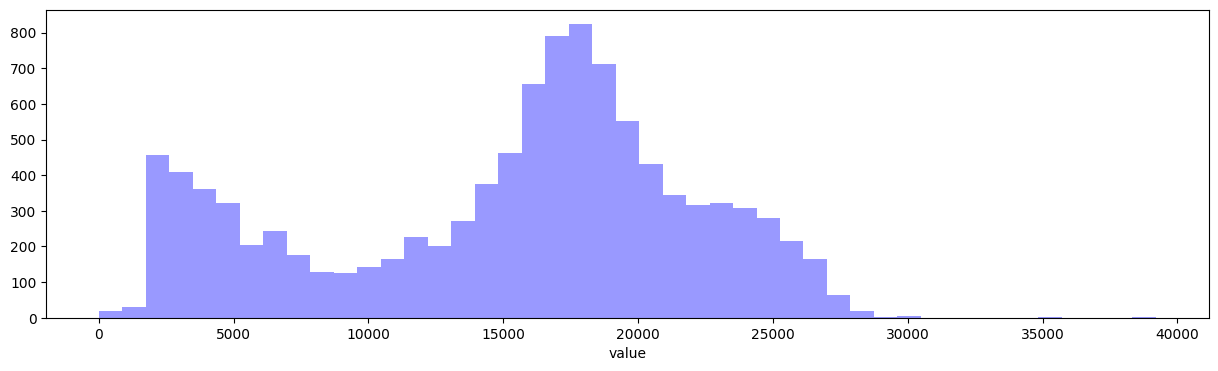

In [19]:
# distribution de la variable nombre de passagers
plt.figure(figsize=(15,4))
fig = sns.distplot(df["value"], kde=False, color="blue")
plt.show()

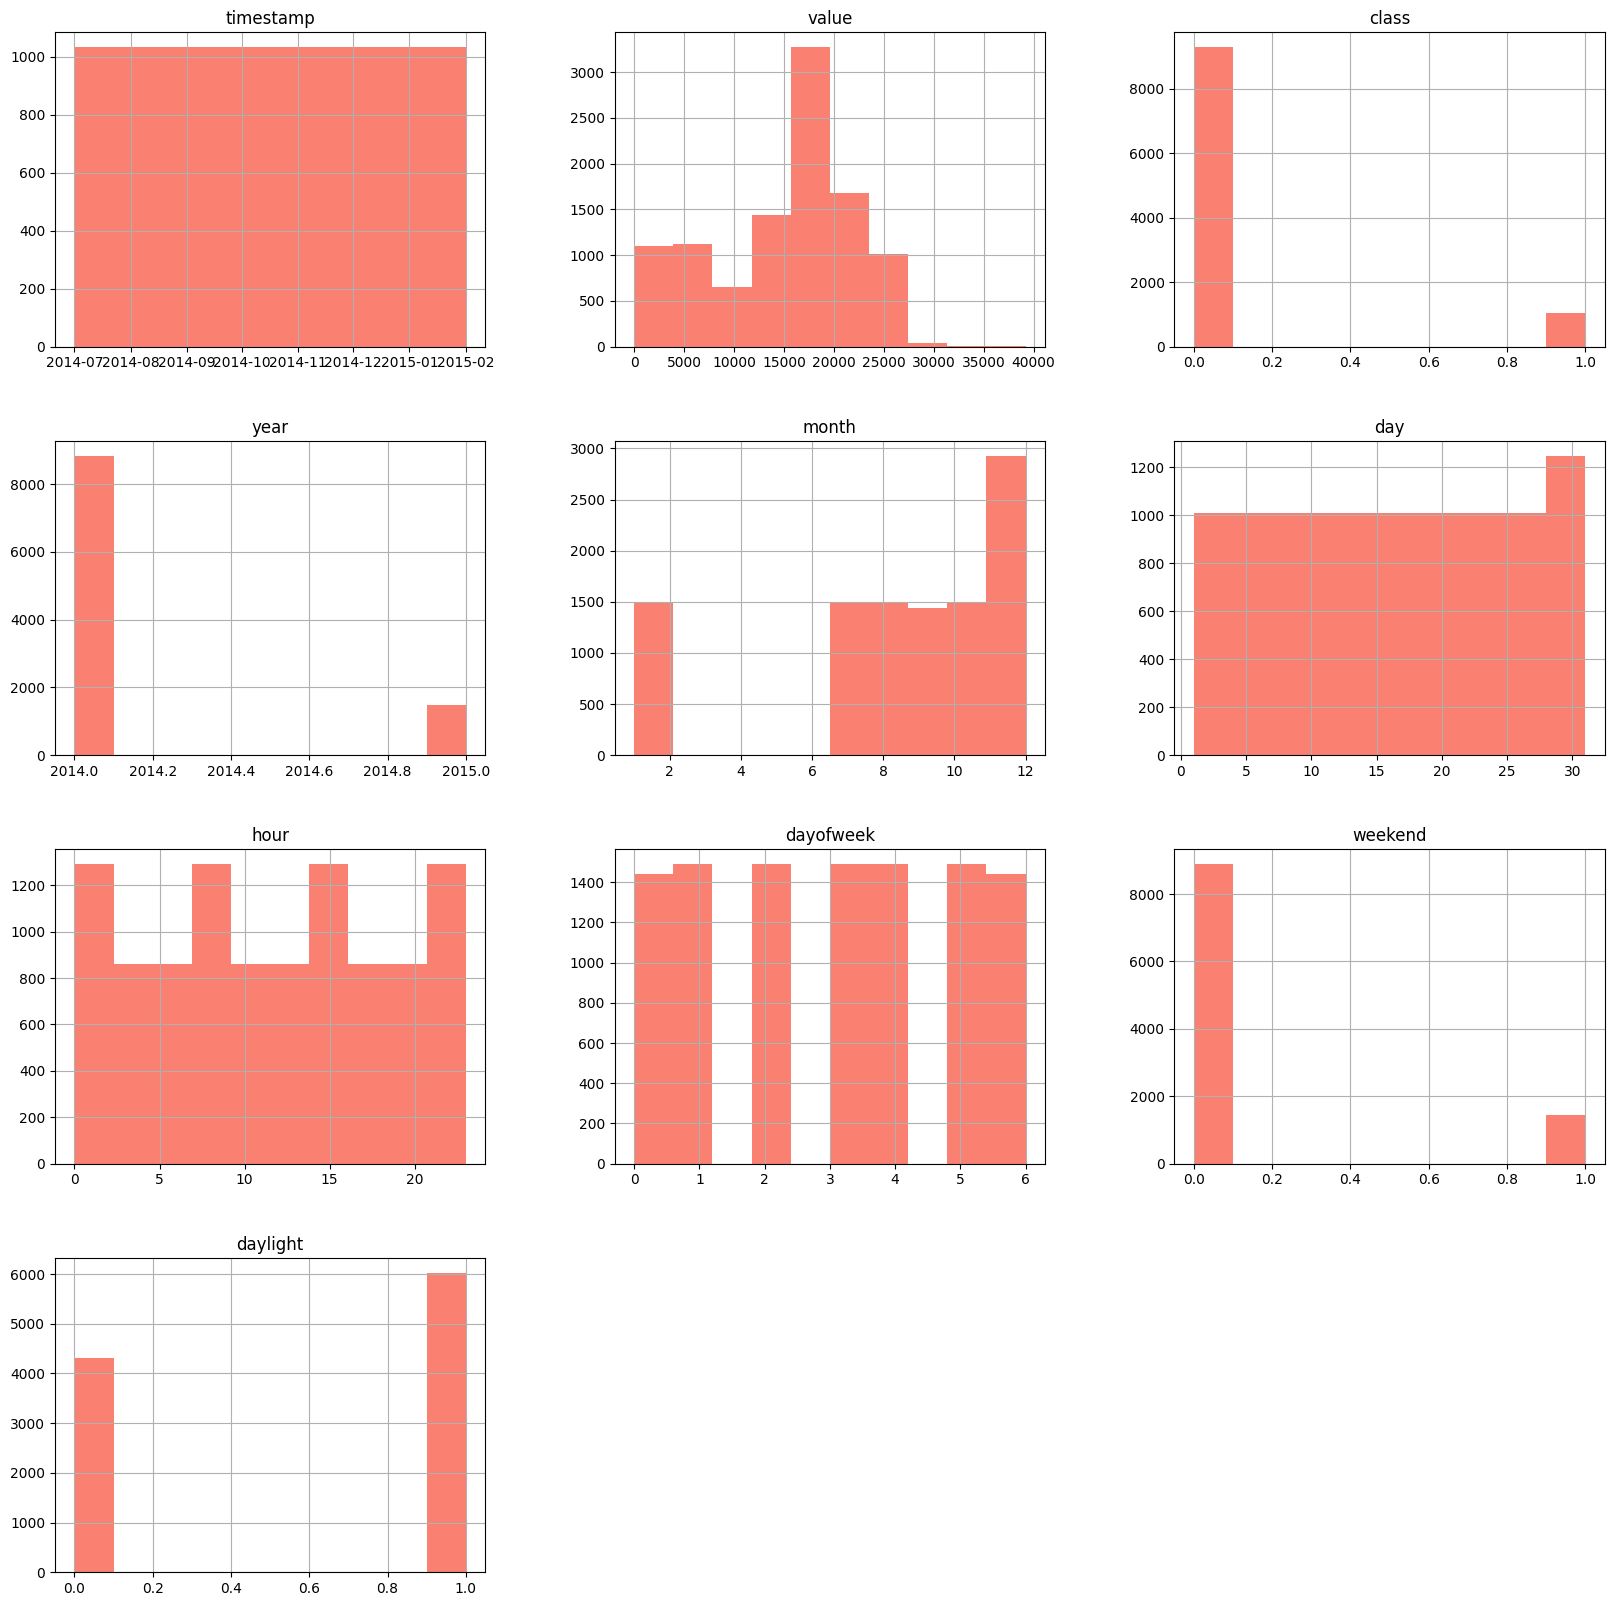

In [20]:
# distribution de toutes les variables
df.hist(figsize=(20,20), color = "salmon")
plt.show()

### Exploration de la série temporelle

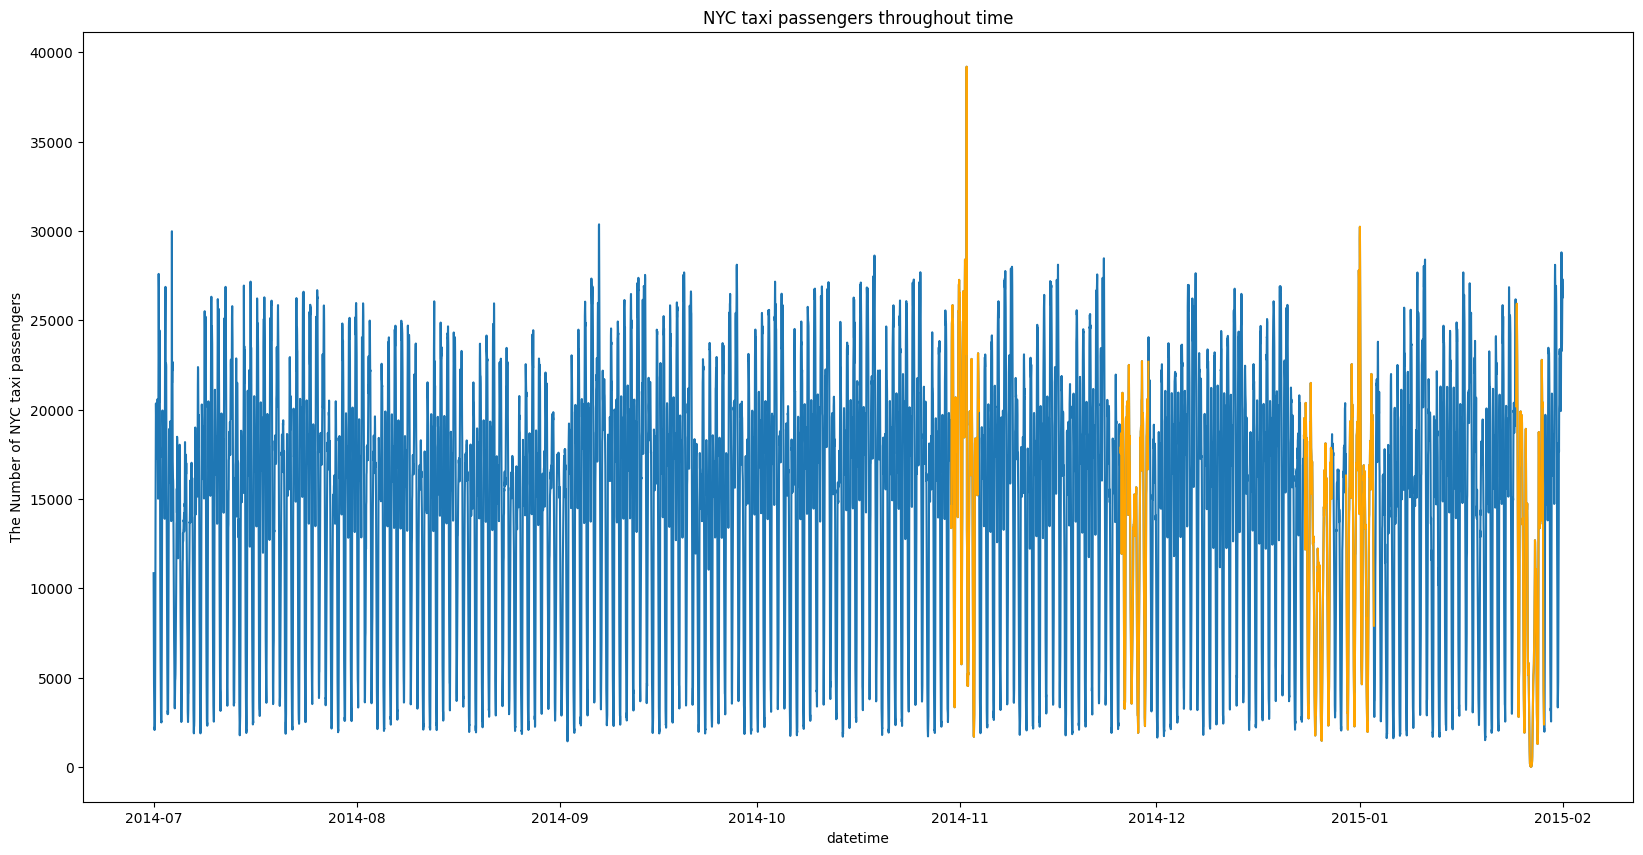

In [21]:
# affiche la serie temporelle

plt.figure(figsize = (20, 10))

# time serie
sns.lineplot(x='timestamp', y='value', data=df)

# anomalies
for start, end in anomaly_points:
    sns.lineplot(x='timestamp', y='value', data=df[((df['timestamp'] > start) & (df['timestamp'] < end))], color='orange')

# legend
plt.title('NYC taxi passengers throughout time')
plt.xlabel('datetime')
plt.ylabel('The Number of NYC taxi passengers')
plt.show()

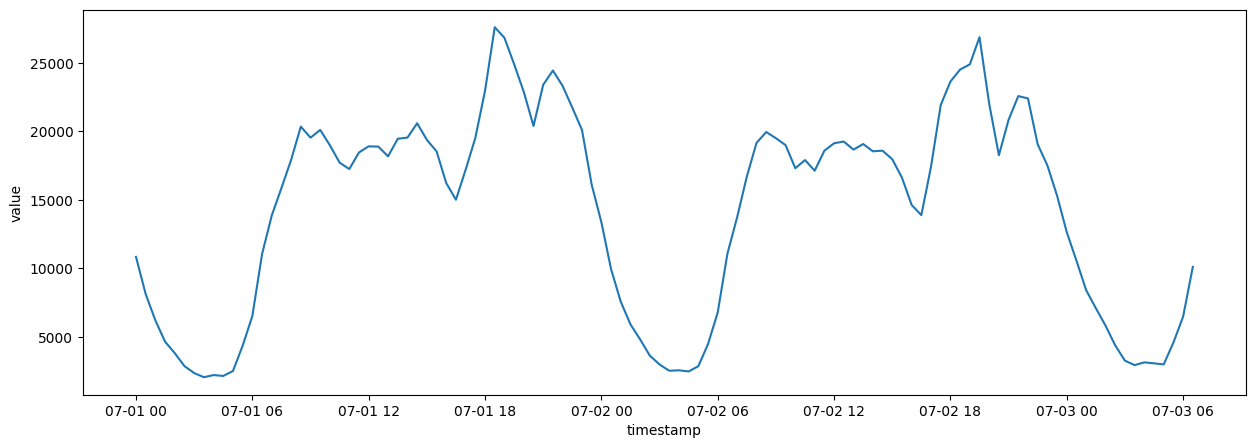

In [22]:
# pour connaitre la periode (= 1 jour = 48 demi-heures)
plt.figure(figsize = (15, 5))
sns.lineplot(x='timestamp', y='value', data=df[0:110])
plt.show()

In [45]:
df.shape

(10320, 10)

<Figure size 5600x2400 with 0 Axes>

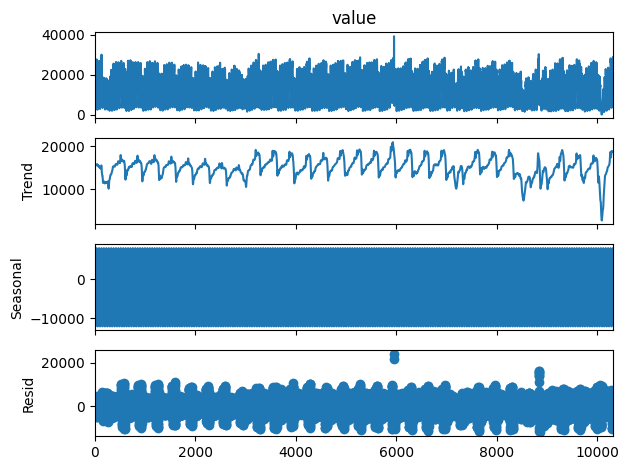

In [51]:
# decomposition de la serie
plt.figure(figsize = (70, 30), dpi=80)
res = seasonal_decompose(df['value'], model='additive', period=48)
res.plot()
plt.show()

### Exploration par heure

C:\Users\Josh\AppData\Local\Temp\ipykernel_8776\3587065943.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp_df = df.groupby(['hour']).mean().reset_index()


<Axes: xlabel='hour', ylabel='value'>

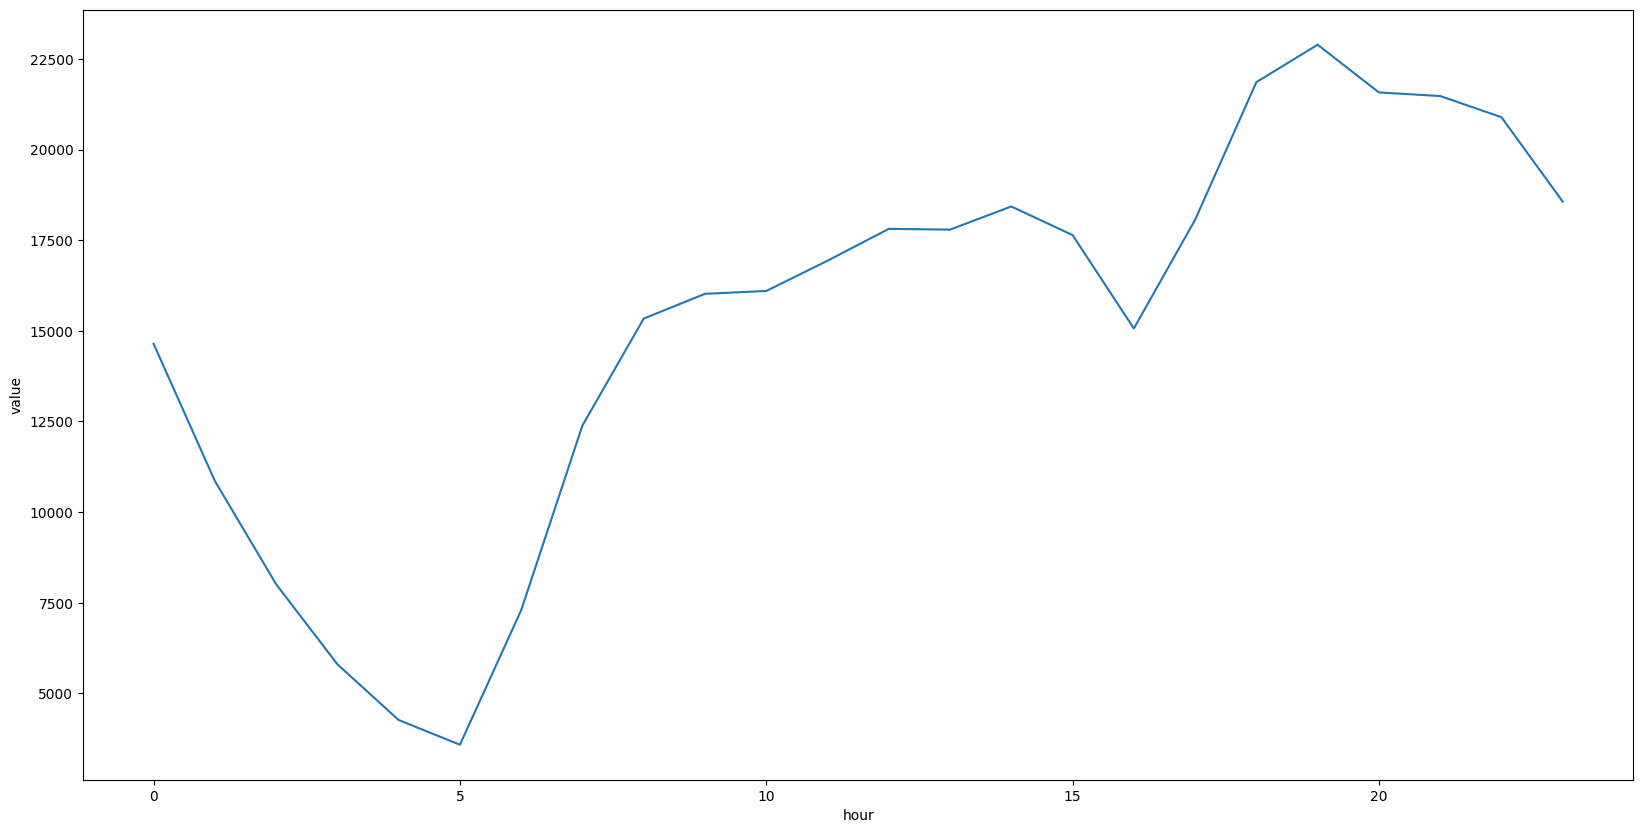

In [24]:
# exploration par heure
tmp_df = df.groupby(['hour']).mean().reset_index()
plt.figure(figsize=(20,10))
sns.lineplot(data=tmp_df, x='hour', y='value')

C:\Users\Josh\AppData\Local\Temp\ipykernel_8776\3908300426.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp_df = df.groupby(['class', 'hour']).mean().reset_index()


<Axes: xlabel='hour', ylabel='value'>

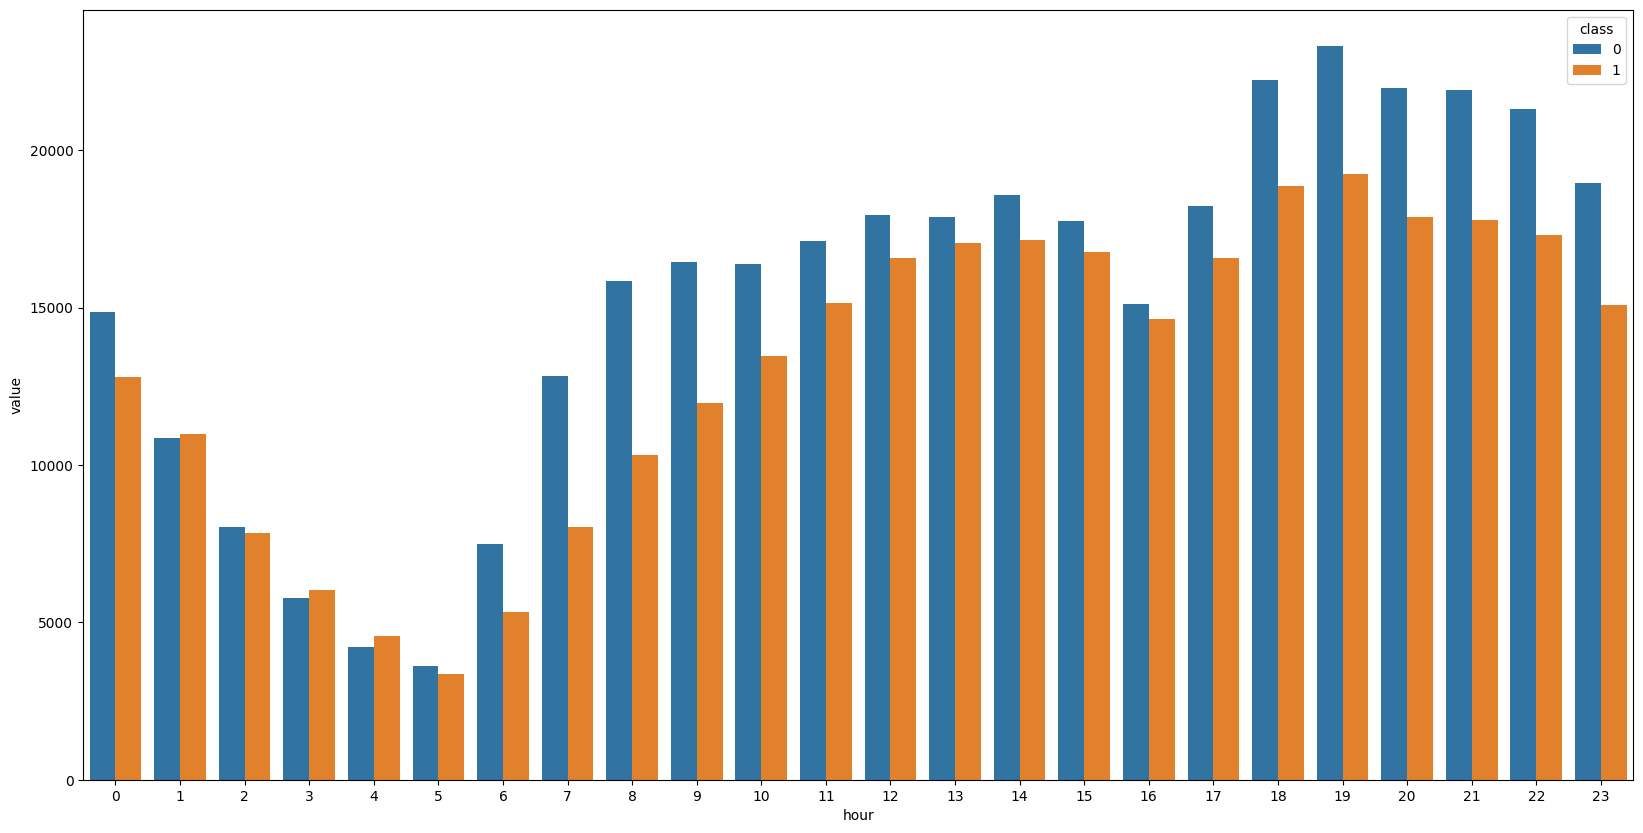

In [25]:
# exploration par heure et par anomalie
tmp_df = df.groupby(['class', 'hour']).mean().reset_index()
plt.figure(figsize=(20,10))
sns.barplot(data=tmp_df, x='hour', y='value', hue="class")

### Exploration selon la luminosité (jour/nuit)

C:\Users\Josh\AppData\Local\Temp\ipykernel_8776\3328634122.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp_df = df.groupby(['daylight', 'dayofweek']).mean().reset_index()


<Axes: xlabel='dayofweek', ylabel='value'>

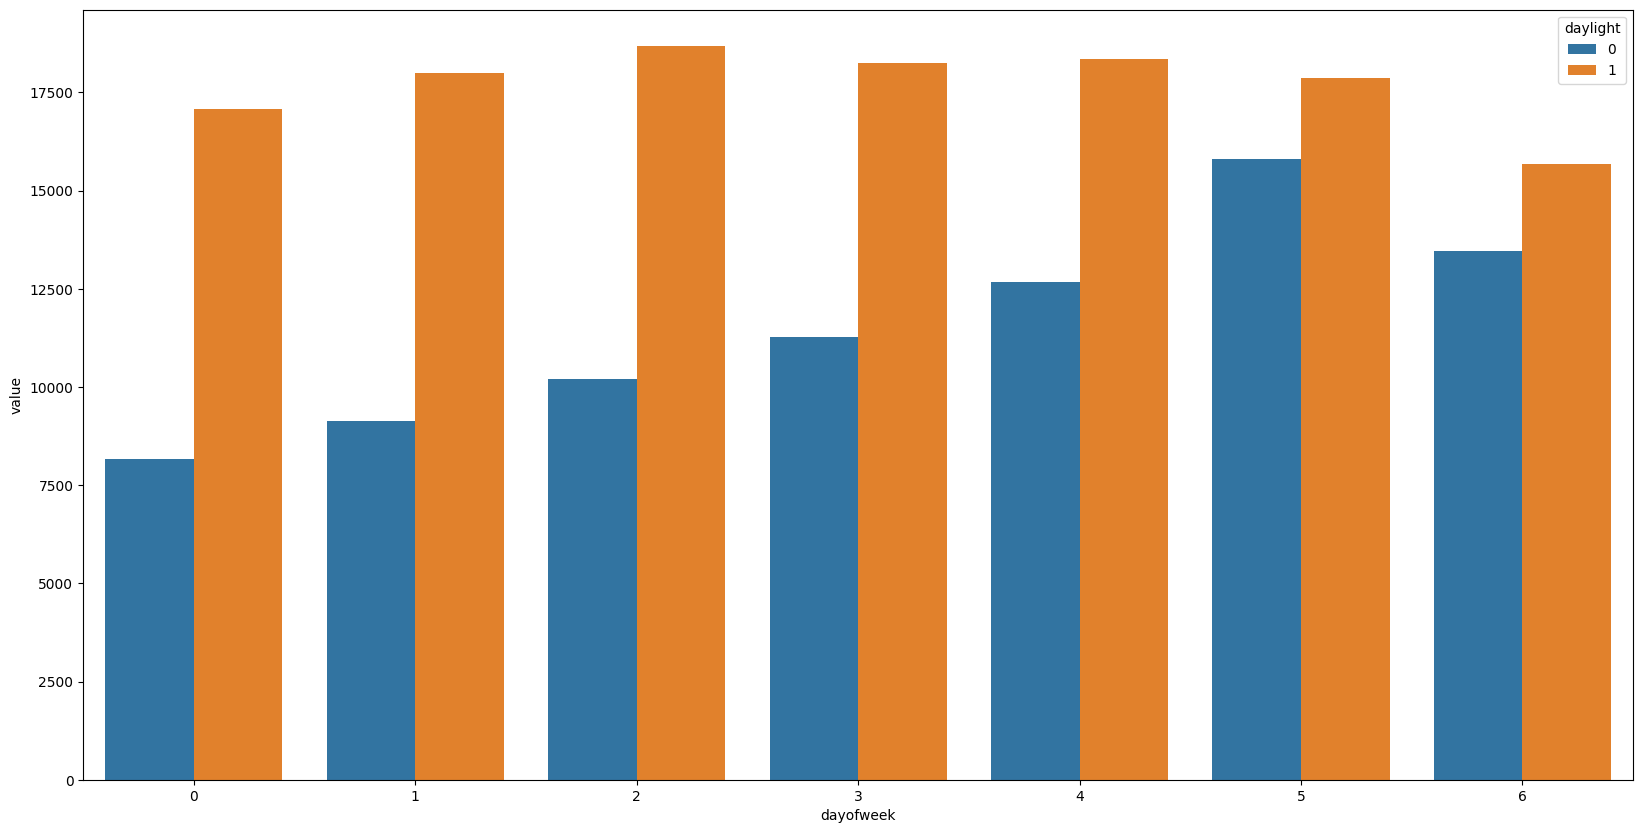

In [26]:
# exploration par luminosite et par journee
tmp_df = df.groupby(['daylight', 'dayofweek']).mean().reset_index()
plt.figure(figsize=(20,10))
sns.barplot(data=tmp_df, x='dayofweek', y='value', hue="daylight")

C:\Users\Josh\AppData\Local\Temp\ipykernel_8776\82595558.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp_df = df.groupby(['class', 'daylight']).mean().reset_index()


<Axes: xlabel='daylight', ylabel='value'>

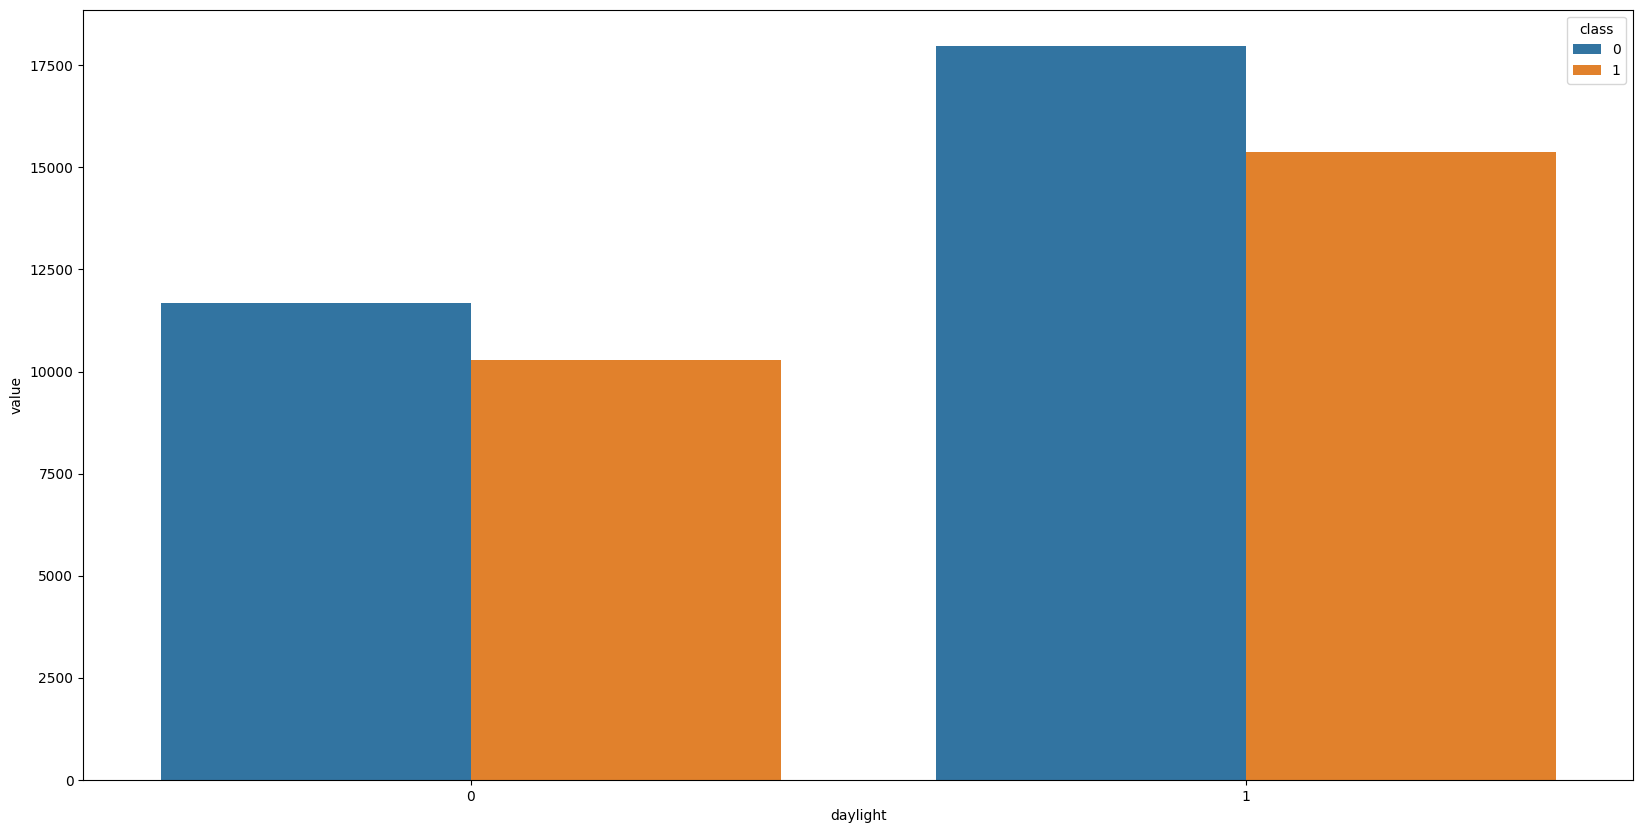

In [27]:
# exploration par luminosite et par anomalie
tmp_df = df.groupby(['class', 'daylight']).mean().reset_index()
plt.figure(figsize=(20,10))
sns.barplot(data=tmp_df, x='daylight', y='value', hue="class")

### Exploration par journée

C:\Users\Josh\AppData\Local\Temp\ipykernel_8776\3271642135.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp_df = df.groupby(['dayofweek']).mean().reset_index()


<Axes: xlabel='dayofweek', ylabel='value'>

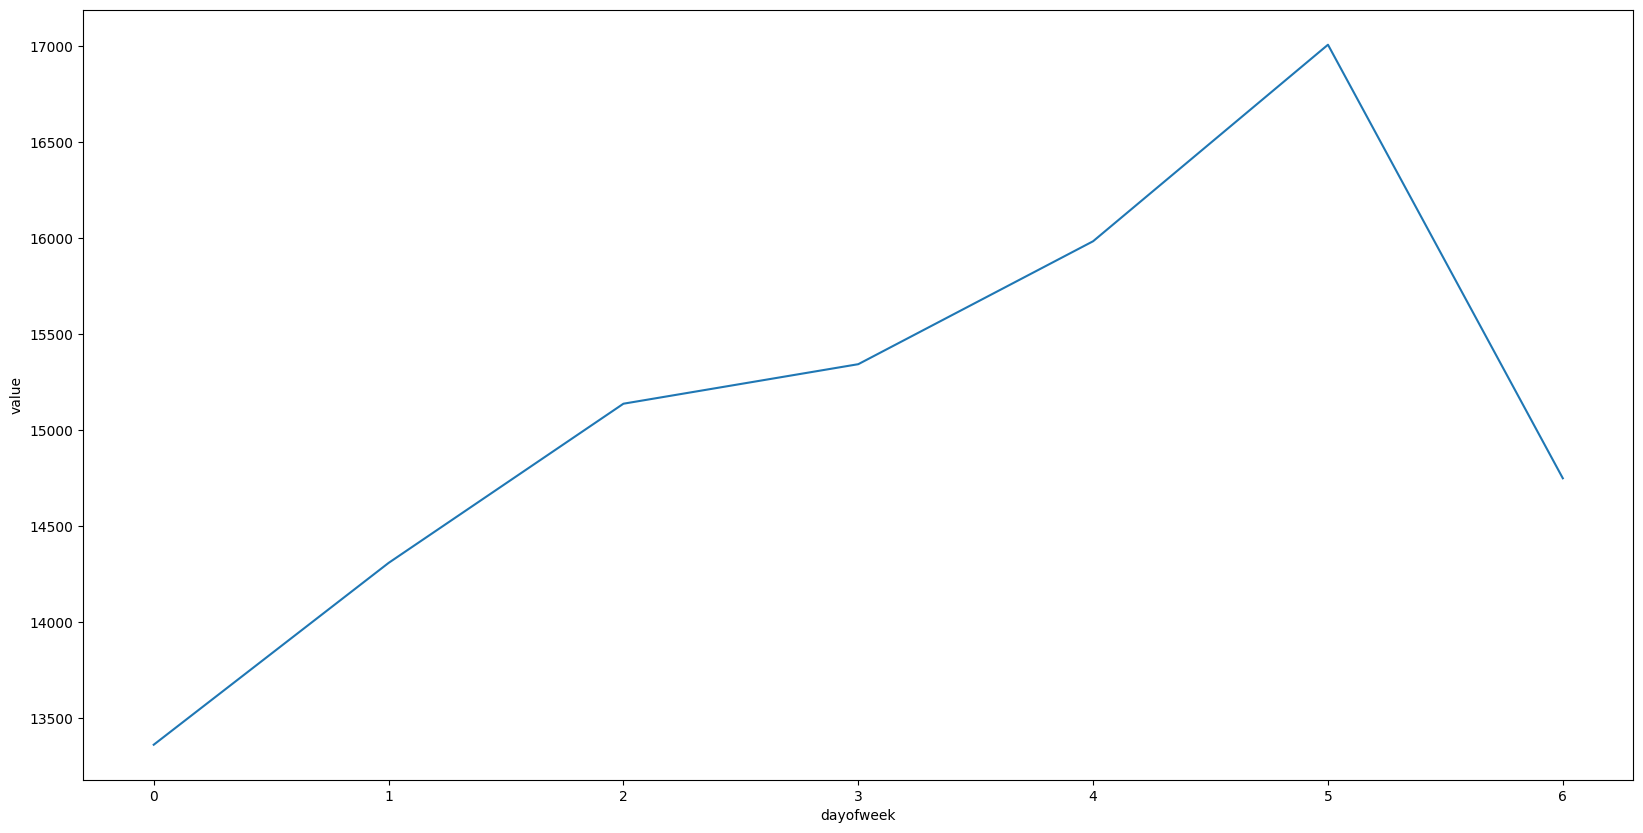

In [28]:
# exploration par journee
tmp_df = df.groupby(['dayofweek']).mean().reset_index()
plt.figure(figsize=(20,10))
sns.lineplot(data=tmp_df, x='dayofweek', y='value')

C:\Users\Josh\AppData\Local\Temp\ipykernel_8776\1815661038.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp_df = df.groupby(['hour', 'dayofweek']).mean().reset_index()


<Axes: xlabel='dayofweek', ylabel='value'>

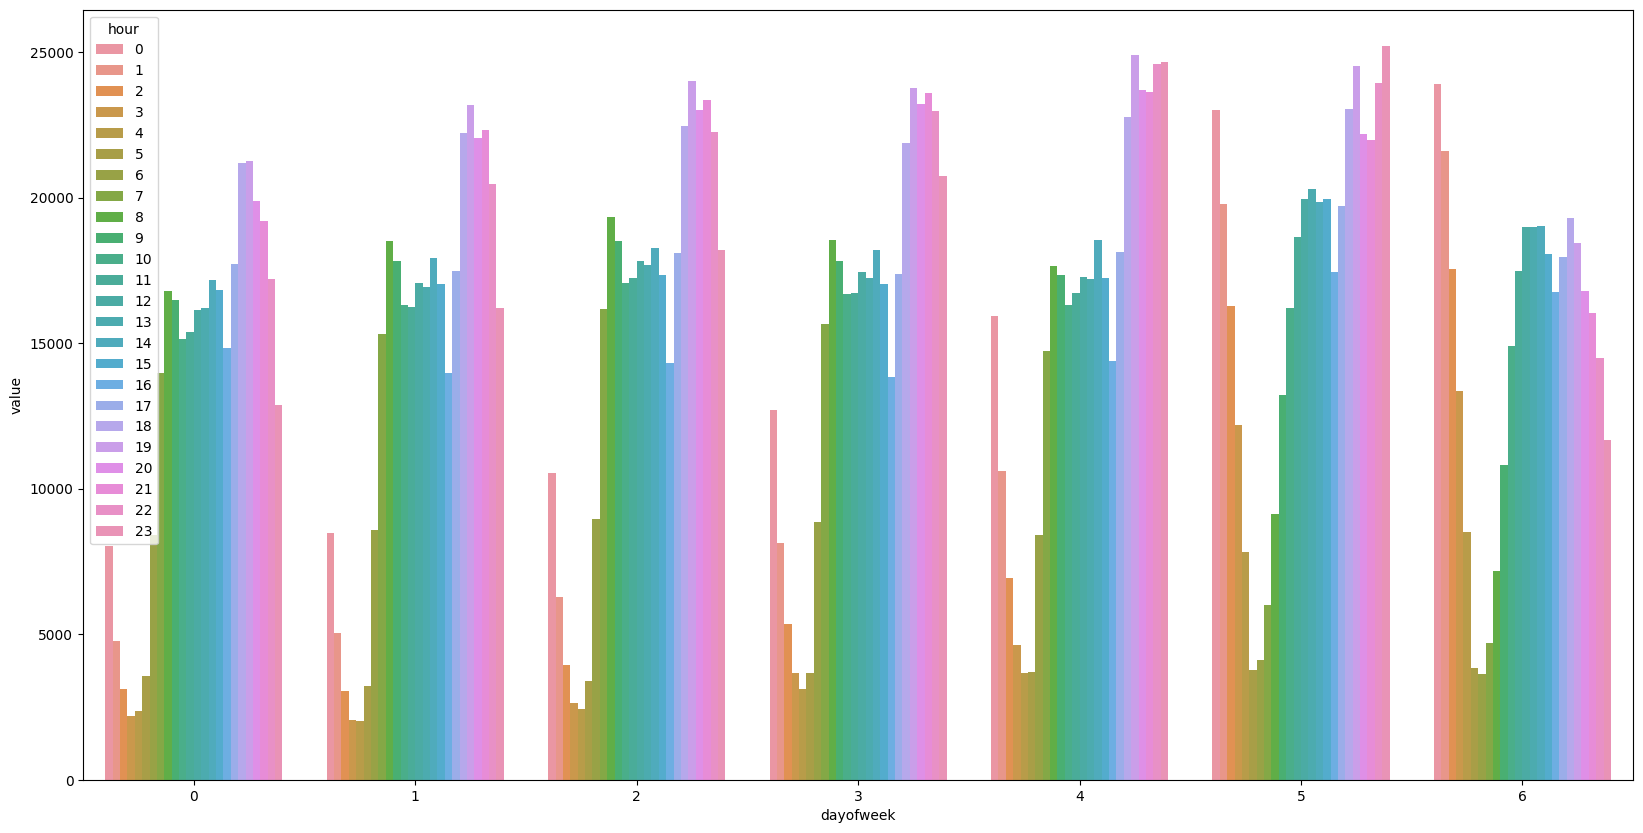

In [29]:
# exploration par journee et par heure
tmp_df = df.groupby(['hour', 'dayofweek']).mean().reset_index()
plt.figure(figsize=(20,10))
sns.barplot(data=tmp_df, x='dayofweek', y='value', hue="hour")

C:\Users\Josh\AppData\Local\Temp\ipykernel_8776\2585732198.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp_df = df.groupby(['class', 'dayofweek']).mean().reset_index()


<Axes: xlabel='dayofweek', ylabel='value'>

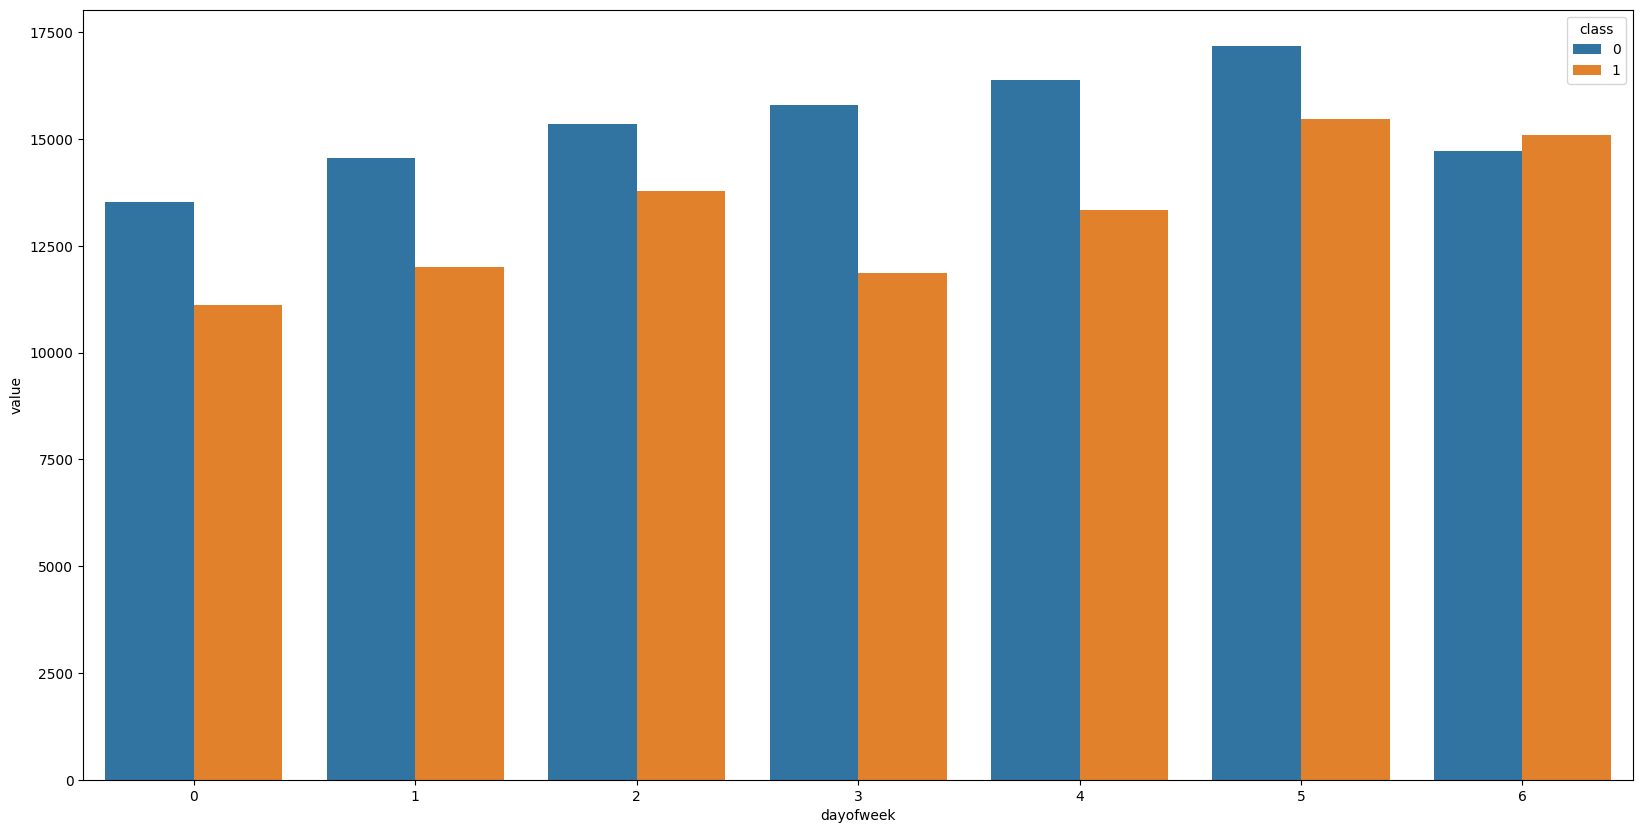

In [30]:
# exploration par journee et par anomalie
tmp_df = df.groupby(['class', 'dayofweek']).mean().reset_index()
plt.figure(figsize=(20,10))
sns.barplot(data=tmp_df, x='dayofweek', y='value', hue="class")

### Exploration par mois

C:\Users\Josh\AppData\Local\Temp\ipykernel_8776\1022404563.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp_df = df.groupby(['month']).mean().reset_index()


<Axes: xlabel='month', ylabel='value'>

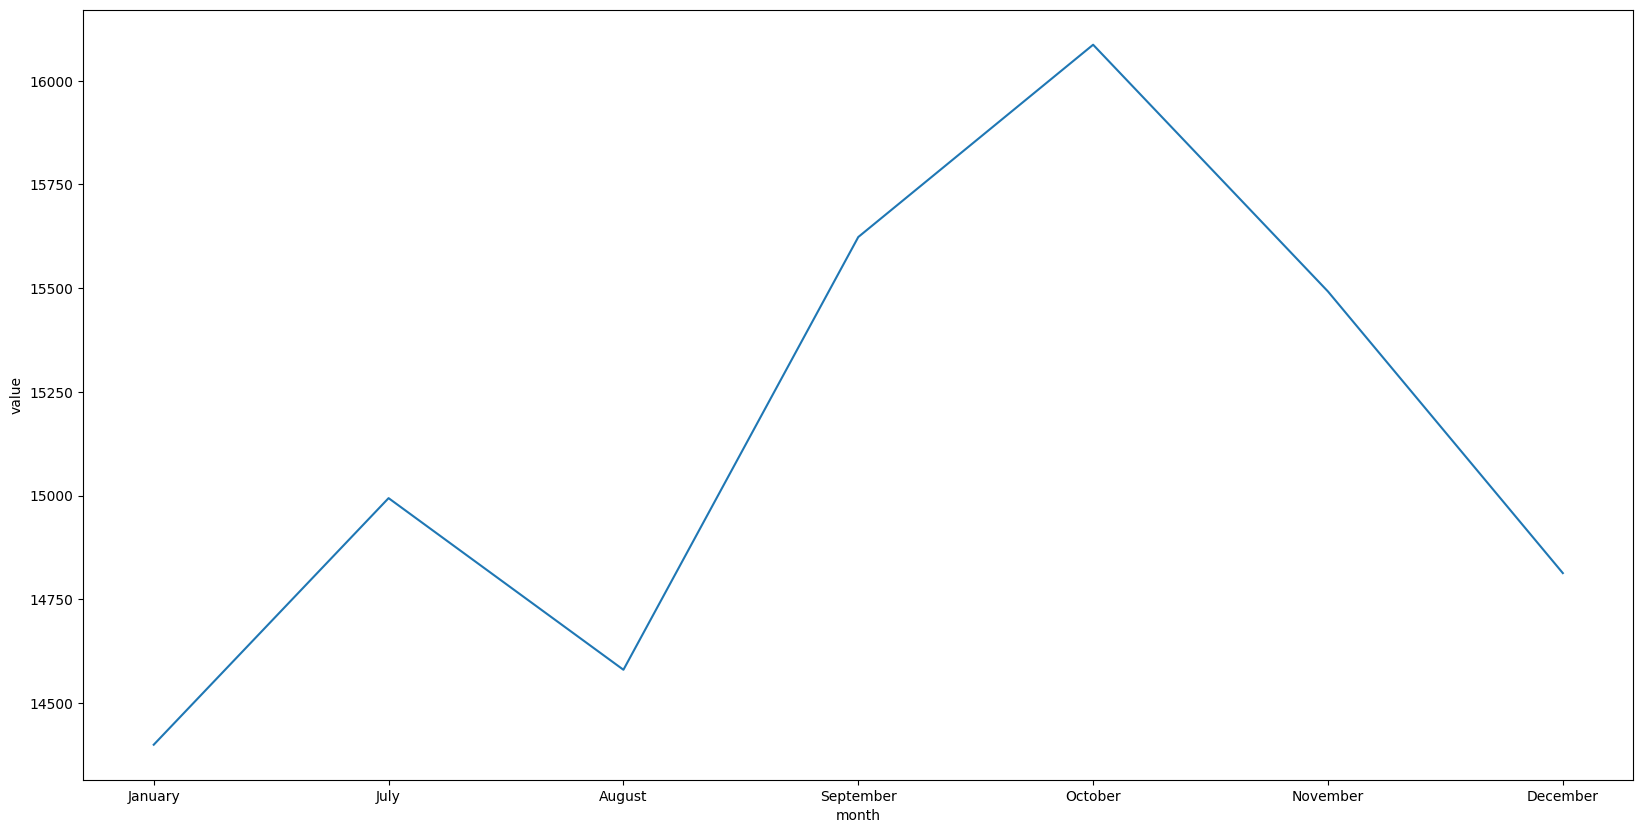

In [31]:
# exploration par mois
tmp_df = df.groupby(['month']).mean().reset_index()
tmp_df['month'] = tmp_df['month'].map({7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December', 1:'January'})
plt.figure(figsize=(20,10))
sns.lineplot(data=tmp_df, x='month', y='value')

C:\Users\Josh\AppData\Local\Temp\ipykernel_8776\3721086214.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp_df = df.groupby(['dayofweek', 'month']).mean().reset_index()


<Axes: xlabel='month', ylabel='value'>

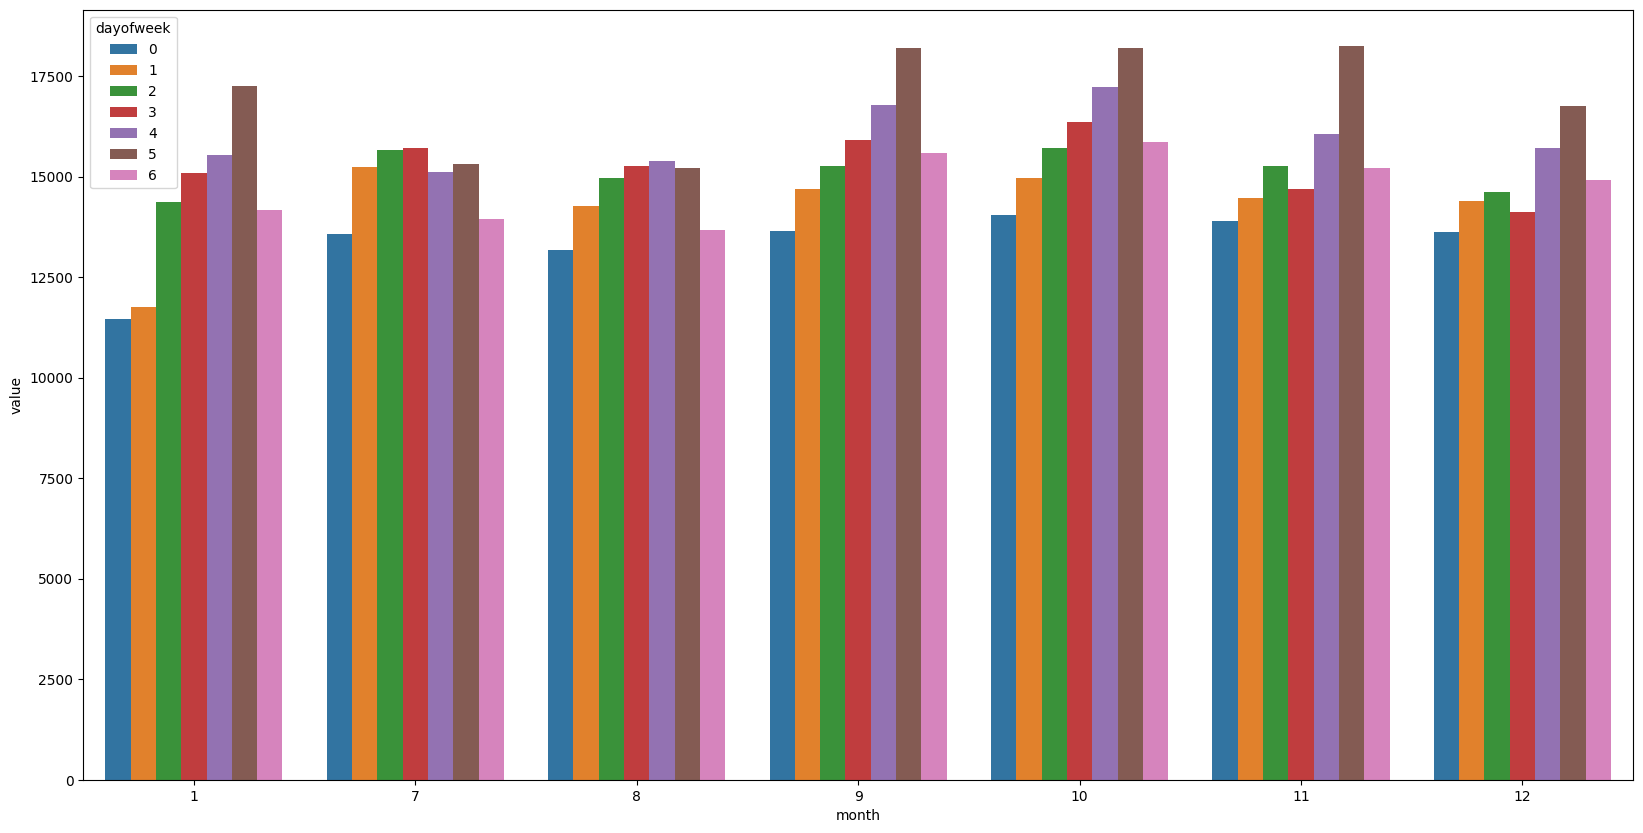

In [32]:
# exploration par mois et par journee
tmp_df = df.groupby(['dayofweek', 'month']).mean().reset_index()
plt.figure(figsize=(20,10))
sns.barplot(data=tmp_df, x='month', y='value', hue="dayofweek")

C:\Users\Josh\AppData\Local\Temp\ipykernel_8776\4109659674.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp_df = df.groupby(['class', 'month']).mean().reset_index()


<Axes: xlabel='month', ylabel='value'>

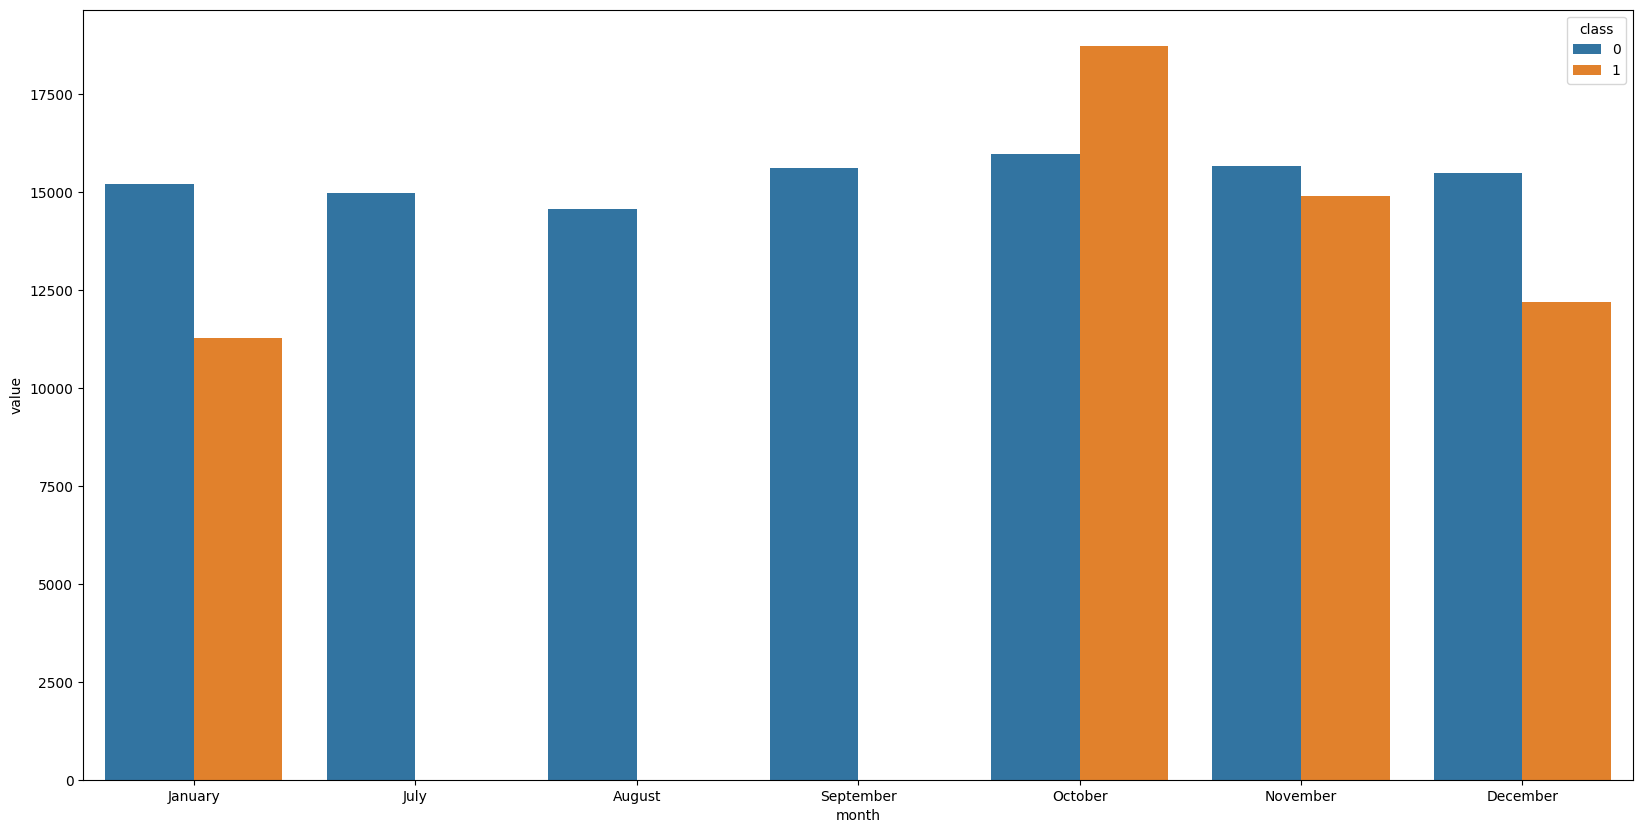

In [33]:
# exploration par mois et par anomalie
tmp_df = df.groupby(['class', 'month']).mean().reset_index()
tmp_df['month'] = tmp_df['month'].map({7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December', 1:'January'})
plt.figure(figsize=(20,10))
sns.barplot(data=tmp_df, x='month', y='value', hue="class")

C:\Users\Josh\AppData\Local\Temp\ipykernel_8776\2077457618.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp_df['mean'] = df.groupby(['month']).mean()['value']


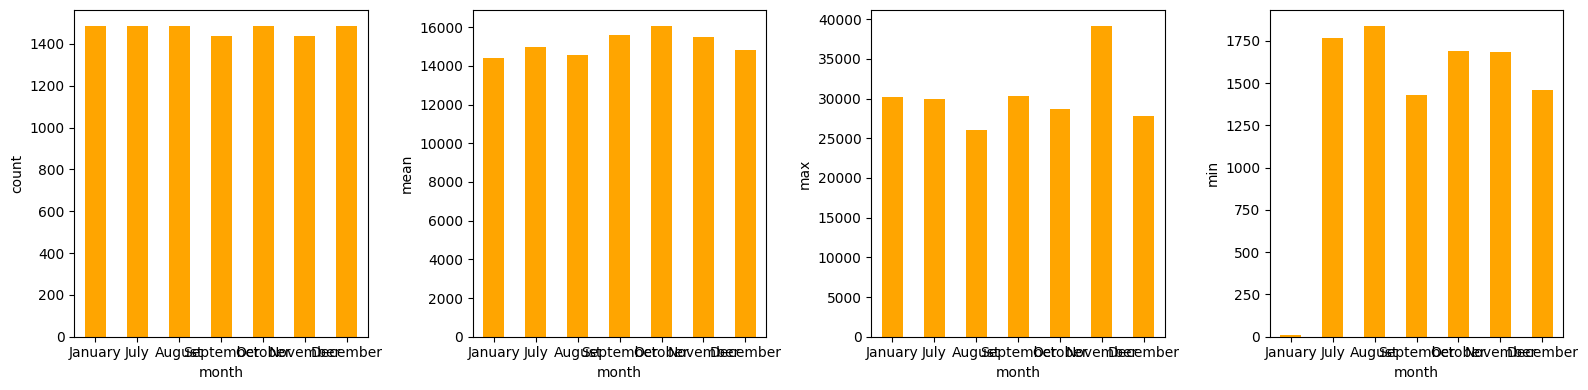

In [34]:
# exploration des dispersions des mois
tmp_df=pd.DataFrame(columns=['count', 'mean', 'max', 'min'])

tmp_df['count'] = df.groupby(['month']).count()['value']
tmp_df['mean'] = df.groupby(['month']).mean()['value']
tmp_df['max'] = df.groupby(['month']).max()['value']
tmp_df['min'] = df.groupby(['month']).min()['value']

# Change month numbers to names
tmp_df.rename(index={7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December', 1:'January'}, inplace=True)

plt.figure(figsize=(16,4))
for i, col in enumerate(tmp_df.columns):
    plt.subplot(1,4,i+1)
    tmp_df[col].plot.bar(ylabel=col, rot=0, color='orange')
    
plt.tight_layout()
plt.show()

C:\Users\Josh\AppData\Local\Temp\ipykernel_8776\3425400647.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['month'] = tmp_df['month'].map({7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December', 1:'January'})


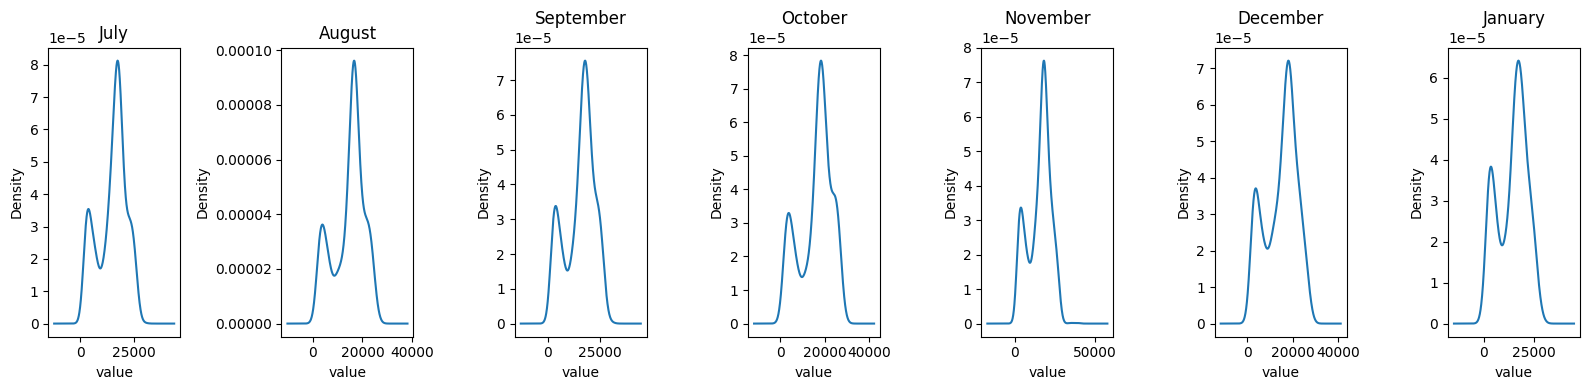

In [35]:
# exploration des densites des mois
tmp_df = df[['value','month']]

# Change month numbers to names
tmp_df['month'] = tmp_df['month'].map({7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December', 1:'January'})

plt.figure(figsize=(16,4))
for i, month in enumerate(tmp_df['month'].unique()):
    plt.subplot(1,7,i+1)
    tmp_df[tmp_df['month']==month]["value"].plot(kind='density')
    plt.xlabel('value')
    plt.title(month)
    
plt.tight_layout()
plt.show()